# Interpretability of heartbeat classification using an LSTM model and Grad-CAM

In [41]:
# Imports:
import numpy as np
import glob
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import os
import matplotlib.cm as cm
import seaborn as sns
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
sns.set()
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, MaxPooling1D, Flatten, LSTM, Dropout
from itertools import islice
from sklearn.preprocessing import normalize
length = 277

### Extract task-specific data and one-hot encode labels

In [2]:
# Load the training and testing data:
train_values = np.empty(shape=[0, length])
test_values = np.empty(shape=[0, length])

train_beats = glob.glob('./train_beats.csv')
test_beats = glob.glob('./test_beats.csv')

for j in train_beats:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    train_values = np.append(train_values, csvrows, axis=0)

for j in test_beats:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    test_values = np.append(test_values, csvrows, axis=0)
    
print(train_values.shape)
print(test_values.shape)

# Separate the training and testing data, and one-hot encode Y:
X_train = train_values[:,:-2]
X_test = test_values[:,:-2]

X_train = X_train.reshape(-1, X_train.shape[1], 1)
X_test = X_test.reshape(-1, X_test.shape[1], 1)

y_train = train_values[:,-2]
y_test = test_values[:,-2]

y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

Loading  ../../../mimic3-code-main/module2_week1/train_beats.csv
Loading  ../../../mimic3-code-main/module2_week1/test_beats.csv
(31912, 277)
(37863, 277)


### Build the LSTM architecture and train the model

In [3]:
verbose, epoch, batch_size = 1, 10, 256
activationFunction='relu'

def getlstmModel():
    lstmmodel = Sequential()
    lstmmodel.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
    lstmmodel.add(LSTM(9, return_sequences=True, name = 'last_lstm_layer', activation='relu'))
    lstmmodel.add(MaxPooling1D(pool_size=4,padding='same'))
    lstmmodel.add(Flatten())
    lstmmodel.add(Dense(256, activation=tf.nn.relu))    
    lstmmodel.add(Dense(128, activation=tf.nn.relu))    
    lstmmodel.add(Dense(32, activation=tf.nn.relu))
    lstmmodel.add(Dense(9, activation='softmax'))
    lstmmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    lstmmodel.summary()
    return lstmmodel

lstmmodel = getlstmModel()
lstmhistory= lstmmodel.fit(X_train, y_train, epochs=epoch, verbose=verbose, validation_split=0.2, batch_size = batch_size)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 275, 128)          66560     
_________________________________________________________________
last_lstm_layer (LSTM)       (None, 275, 9)            4968      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 69, 9)             0         
_________________________________________________________________
flatten (Flatten)            (None, 621)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               159232    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4

In [4]:
# Save the model so we can visualize it with Netron (https://github.com/lutzroeder/netron):
tf.keras.models.save_model(lstmmodel, 'lstmmodel_gradcam_ecg.h5')

### Choose a class to get the Grad-CAM values for

In [104]:
# Get all the data that corresponds to one single class (class 8 / 'I'):
class_num = 8
class_ann = 'I'

N_test = test_values[test_values[:,-2]==class_num]

# To make sure that we do not get out of memory problems when computing the gradients:
if len(N_test) > 2400:
    N_test = N_test[:2400, :]

X_test = N_test[:,:-2]
y_test = N_test[:len(N_test),-2]

X_test1 = X_test.reshape(-1, X_train.shape[1], 1)
y_test1 = to_categorical(y_test)
lstmpredictions = lstmmodel.predict(X_test1, verbose=1)

75/75 [==============================] - 4s 50ms/step


### Create a performance metrics function

In [105]:
def showResults(test, pred, model_name):
    accuracy = accuracy_score(test, pred)
    precision= precision_score(test, pred, average='macro')
    recall = recall_score(test, pred, average = 'macro')
    f1score= f1_score(test, pred, average='macro') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("Recall : {}".format(recall))
    print("f1score : {}".format(f1score))
    cm=confusion_matrix(test, pred, labels=[1,2,3,4,5,6,7,8])
    return (model_name, round(accuracy,3), round(precision,3) , round(recall,3) , round(f1score,3), cm)

### Call the performance metrics function per class

Accuracy  : 0.9791666666666666
Precision : 0.25
Recall : 0.24479166666666666
f1score : 0.2473684210526316


C:\Program Files\Python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-106-c1316649d302>:8: RuntimeWarning: invalid value encountered in true_divide
  LSTM_cf_m = lstm_results[5].astype('float')/ lstm_results[5].sum(axis=1)[:,np.newaxis]


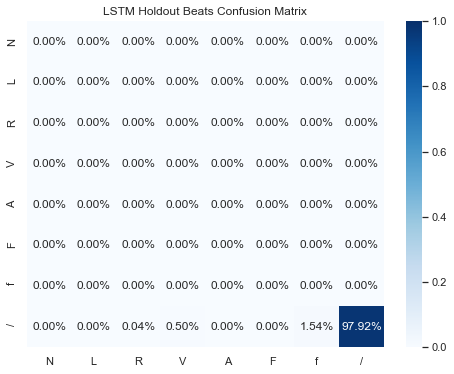

In [106]:
lstm_predict = np.argmax(lstmpredictions,axis=1)
lstm_actual_value = np.argmax(y_test1,axis=1)
lstm_results = showResults(lstm_actual_value, lstm_predict,'LSTM')

# Plot confusion matrix:
categories=['N','L','R','V','A','F','f','/']
fig = plt.figure(figsize=(8,6))
LSTM_cf_m = lstm_results[5].astype('float')/ lstm_results[5].sum(axis=1)[:,np.newaxis]
sns.heatmap(np.nan_to_num(LSTM_cf_m),annot=True,fmt='.2%',xticklabels=categories,yticklabels=categories,vmin=0,vmax=1,cmap='Blues')
plt.title('LSTM Holdout Beats Confusion Matrix')
plt.show()
fig.savefig('cm.jpg', dpi = 400)

### Compute Grad-CAM values for the class chosen above

In [107]:
# Turn off the final Softmax activation function:
lstmmodel.layers[-1].activation = None

In [108]:
# Create a model that maps the input heartbeat to the feature maps of the last LSTM layer 
# and the output (before applying Softmax):
grad_model = tf.keras.models.Model([lstmmodel.inputs], [lstmmodel.get_layer('last_lstm_layer').output, lstmmodel.output])

# Step 1: Compute the gradient of the output with respect to the feature maps:
with tf.GradientTape() as tape:
    last_lstm_layer_features, y_predictions = grad_model(X_test1)
grads = tape.gradient(y_predictions, last_lstm_layer_features)

# Step 2: Calculate alpha values by averaging the gradients:
alpha_values = tf.reduce_mean(grads, axis = 1)

# Step 3: Use the alpha values as the weight of the corresponding feature map: 
gradcam = tf.linalg.matmul(last_lstm_layer_features, alpha_values[..., tf.newaxis])

In [109]:
# Normalize the grad-CAM values for visualization:
gradcam = gradcam.numpy()
gradcam = np.abs(gradcam)
gradcam_norm = (gradcam - np.min(gradcam, axis = 1, keepdims = True)) / (np.max(gradcam, axis = 1, keepdims = True) - 
                                                        np.min(gradcam, axis = 1, keepdims = True))
y_predictions = tf.nn.softmax(y_predictions)
y_predictions = y_predictions.numpy()

### Visualize Grad-CAM results with saliency maps for the correctly classified beats

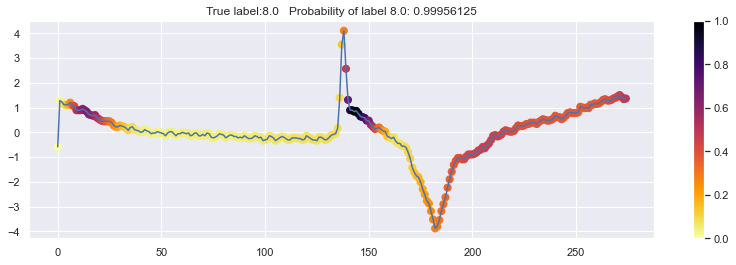

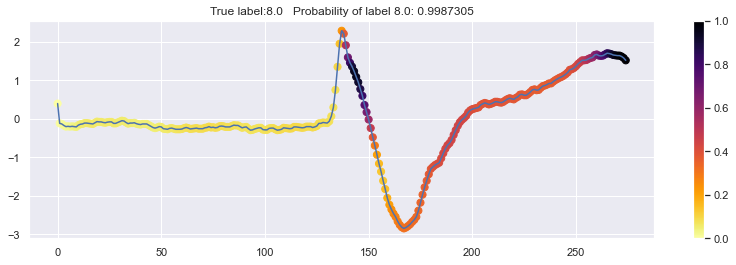

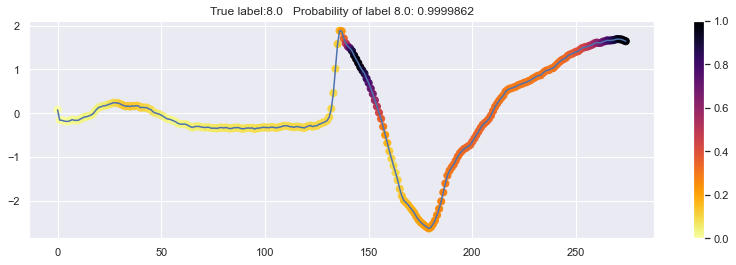

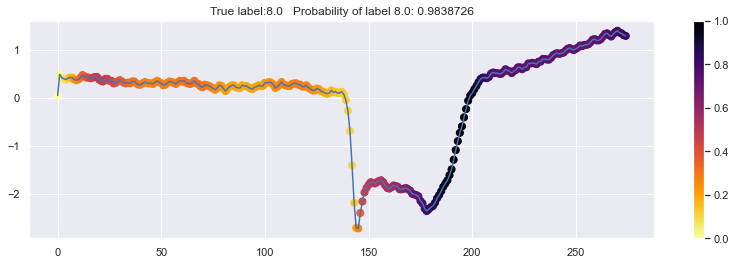

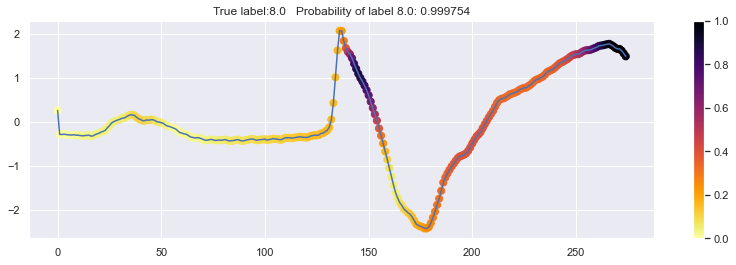

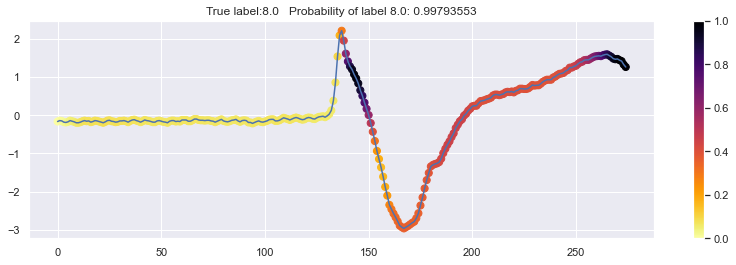

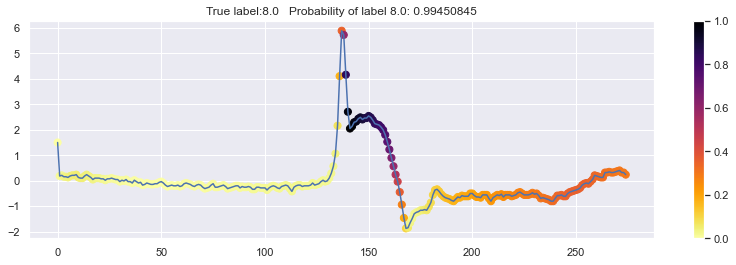

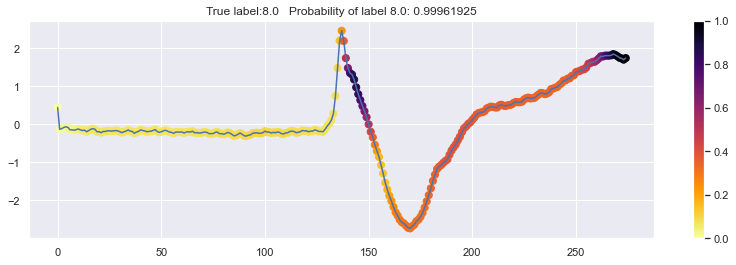

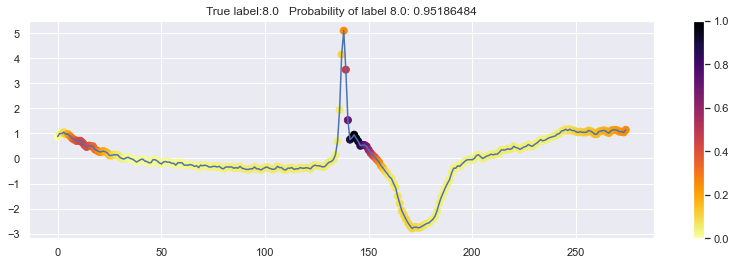

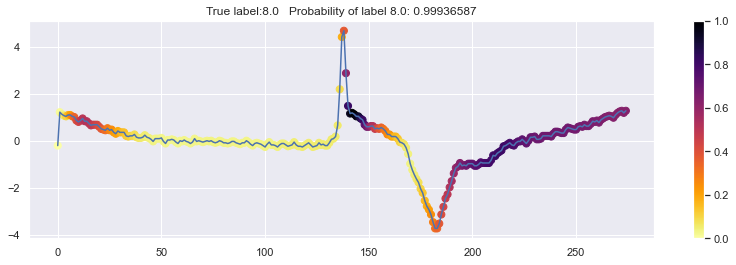

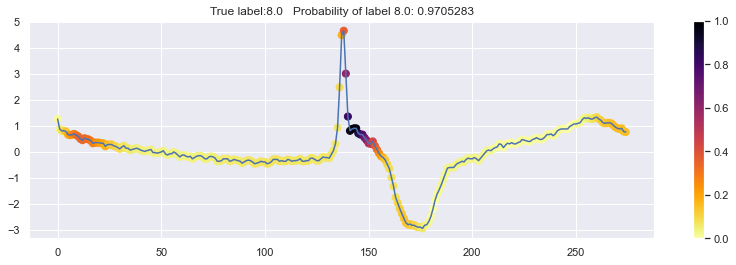

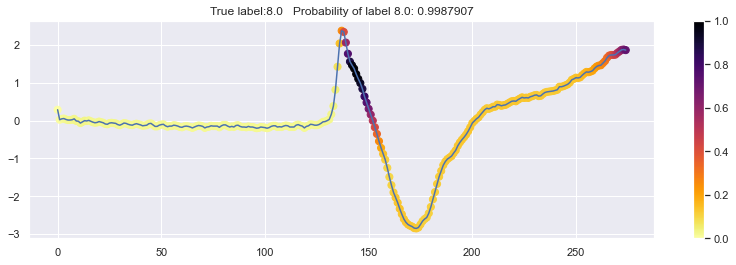

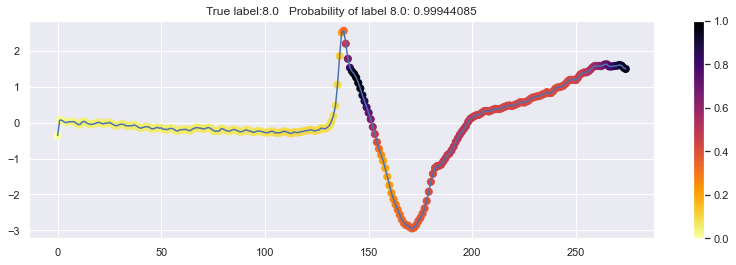

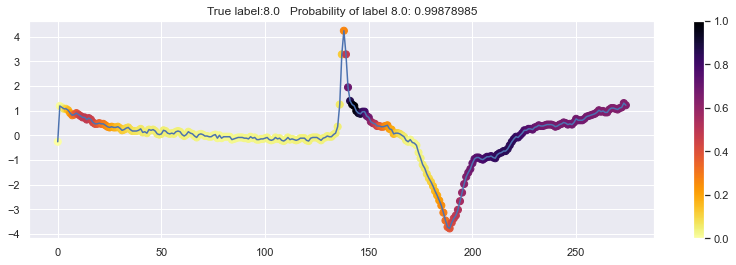

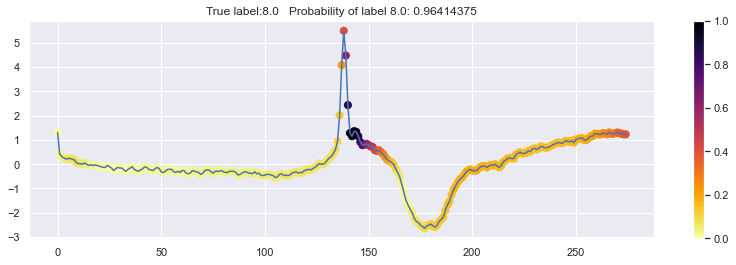

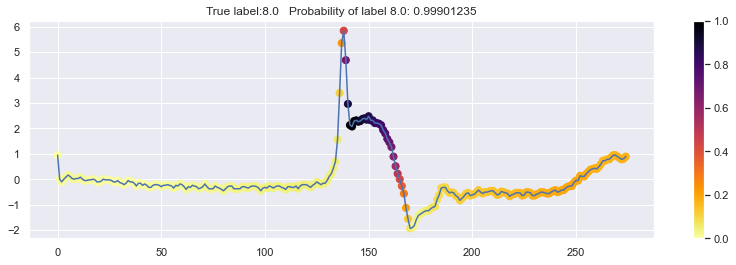

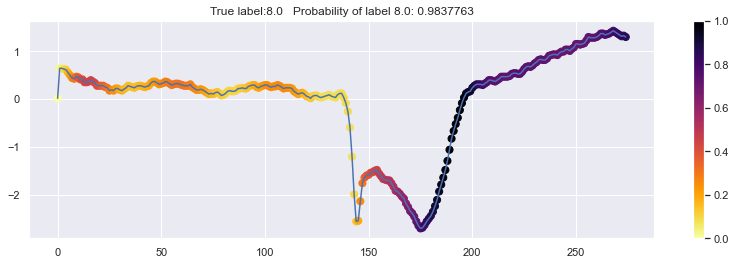

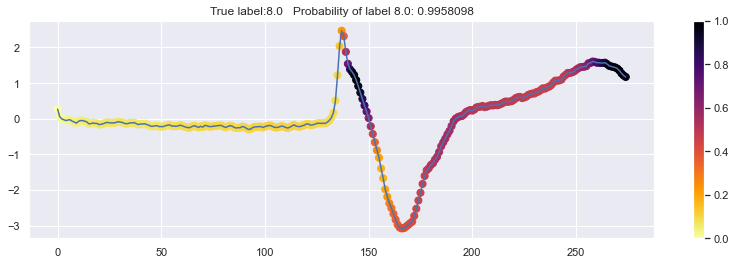

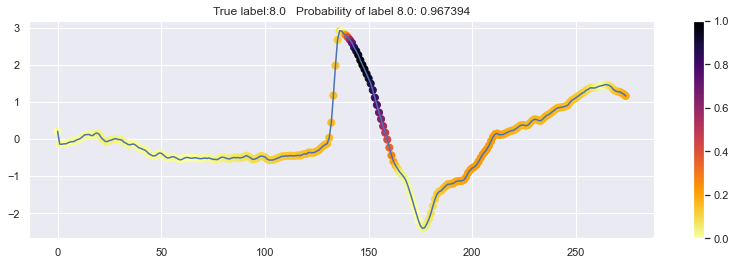

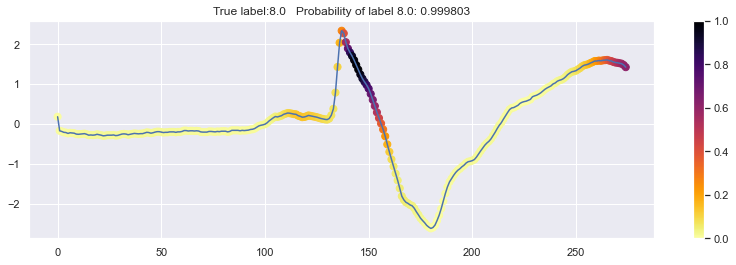

In [110]:
# Get the corectly classified data:
correct_lstm = np.where(lstm_predict == lstm_actual_value)
correct_lstm = correct_lstm[0].tolist()

# Plot a few examples of heatmaps:
for i in correct_lstm[20:40]:
    plt.figure(figsize=(14, 4))
    plt.plot(X_test1[i].squeeze())
    plt.scatter(np.arange(len(X_test1[i])), X_test1[i].squeeze(), cmap='inferno_r', c=gradcam_norm[i,:].squeeze(), s=50)
    plt.title('True label:' + str(y_test[i]) + '   Probability of label ' + str(y_test[i]) + ': ' + str(y_predictions[i, int(y_test[i])]))
    clim= np.ravel(gradcam_norm)
    plt.clim(min(clim),max(clim))
    plt.colorbar()
    plt.show

### Visualize Grad-CAM results with saliency maps for the heartbeats that were not correctly classified

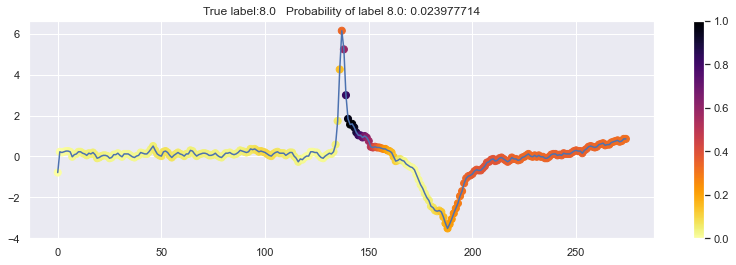

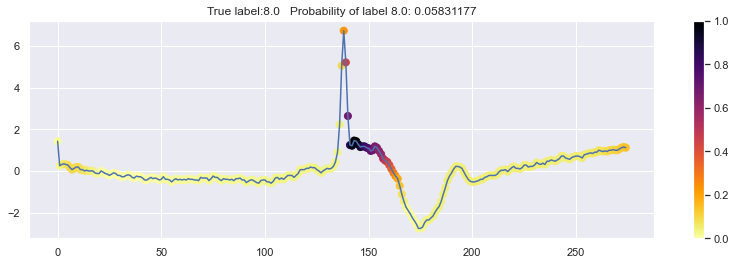

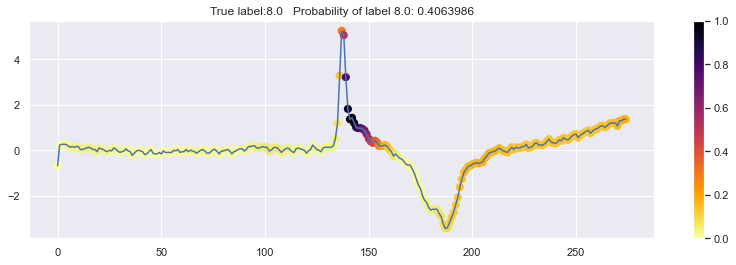

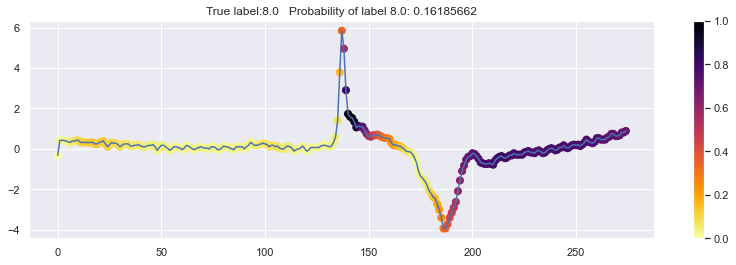

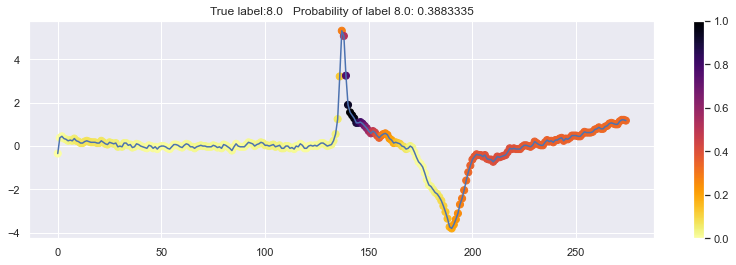

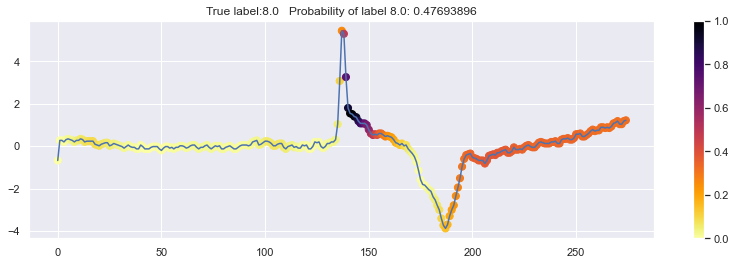

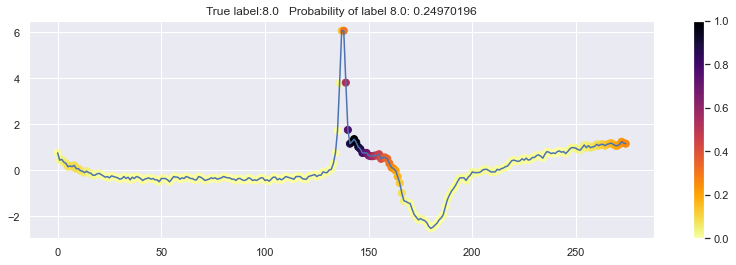

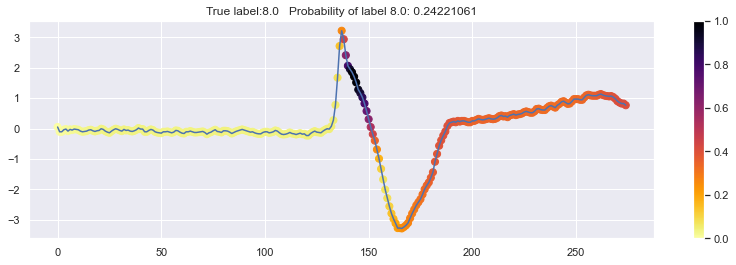

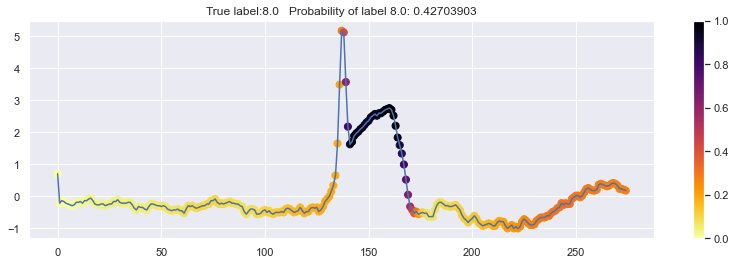

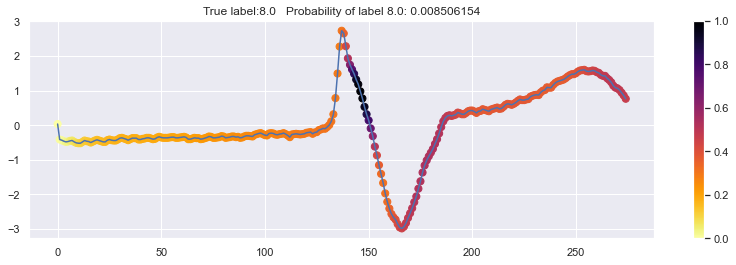

In [111]:
# Get the misclassified data:
misclass_lstm = np.where(lstm_predict != lstm_actual_value)
misclass_lstm = misclass_lstm[0].tolist()

# Plot a few examples of heatmaps:
for i in misclass_lstm[:10]:
    plt.figure(figsize=(14, 4))
    plt.plot(X_test1[i].squeeze())
    plt.scatter(np.arange(len(X_test1[i])), X_test1[i].squeeze(), cmap='inferno_r', c=gradcam_norm[i,:].squeeze(), s=50)
    plt.title('True label:' + str(y_test[i]) + '   Probability of label ' + str(y_test[i]) + ': ' + str(y_predictions[i, int(y_test[i])]))
    clim= np.ravel(gradcam_norm)
    plt.clim(min(clim),max(clim))
    plt.colorbar()
    plt.show

### Divide the  ECG beats into 11 segments and compute the Grad-CAM values per segment

In [112]:
# Means of slice function:
def means_of_slices(iterable, slice_size):
    iterator = iter(iterable)
    while True:
        slice = list(islice(iterator, slice_size))
        if slice:
            yield np.sum(slice)/len(slice)
        else:
            return

# Divide the result into slices:
cam_per_segment = []
for i in range(X_test1.shape[0]):
    means = list(means_of_slices(gradcam_norm[i], 25))
    cam_per_segment.append(means)
cam_per_segment = np.array(cam_per_segment)
print(cam_per_segment.shape)

# Repeat the values 25 times for visualization purposes:
cam_per_segment_repeat = []
for i in cam_per_segment:
    cam_per_segment_repeat.append(np.repeat(i,25))
cam_per_segment_repeat = np.array(cam_per_segment_repeat)
print(cam_per_segment_repeat.shape)

(2400, 11)
(2400, 275)


### Plot the average Grad-CAM values per segment on a sample ECG beat

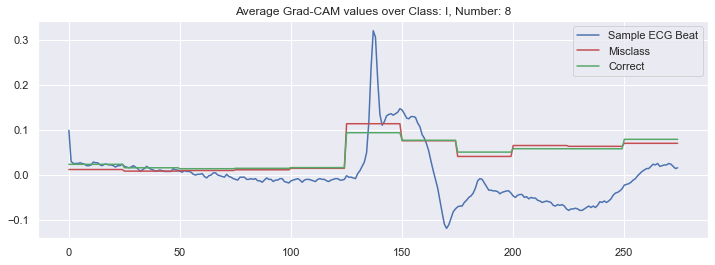

In [113]:
# Normalize correct and incorrect predictions:
ecg_correct_norm = normalize(cam_per_segment_repeat[correct_lstm[:1000]])
ecg_incorrect_norm = normalize(cam_per_segment_repeat[misclass_lstm[:10]])

# Normalize ECG heartbeat example:
ecg_norm = normalize(X_test1[:,:,0])

# Take means of all correct and incorrect segments:
mean_correct = ecg_correct_norm.mean(axis=0)
mean_incorrect = ecg_incorrect_norm.mean(axis=0)

# Visualize:
plt.figure(figsize=(12,4))
plt.plot(ecg_norm[1],color='b',label='Sample ECG Beat')
plt.plot(np.abs(mean_incorrect), color='r', label='Misclass')
plt.plot(np.abs(mean_correct), color='g', label='Correct')
plt.title('Average Grad-CAM values over '+'Class: ' + class_ann +', Number: ' + str(class_num))
plt.legend()
plt.savefig('lstm_gradcam_' + class_ann + '.jpg', bbox_inches='tight',dpi=400)
plt.show()